# A comparative study of clustering methods for hyperspectral data processing

### Ehsan Farahbakhsh<sup>1</sup>, Pulkit Sharma<sup>2</sup>, Aman Agrawal<sup>3</sup>, Rohitash Chandra<sup>4</sup>

<sup>1</sup>*EarthByte Group, School of Geosciences, The University of Sydney, Sydney, Australia*

<sup>2</sup>*JECRC University, Jaipur, Rajasthan, India*

<sup>3</sup>*Indian Institute of Technology, Kanpur, Kanpur, India*

<sup>4</sup>*Transitional Artificial Intelligence Research Group, School of Mathematics and Statistics, University of New South Wales, Sydney, Australia*

This notebook enables the user to apply different clustering algorithms to the Pavia University dataset. Different types of plots can be generated in addition to calculating various performance metrics to compare the efficiency of the algorithms in creating accurate clustered maps.

### Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

from ds_utils.unsupervised import plot_cluster_cardinality
from ipywidgets import interact
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
import seaborn as sns

from sklearn import cluster, mixture
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, completeness_score, homogeneity_score, mutual_info_score, rand_score, v_measure_score
from sklearn.preprocessing import minmax_scale
from skopt import BayesSearchCV
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

### Loading and visualising the dataset

In [2]:
# import the data
data_array = loadmat('Data\PaviaU\PaviaU.mat')['paviaU'] # hyperspectral data
gt = loadmat('Data\PaviaU\PaviaU_gt.mat')['paviaU_gt'] # ground truth data

In [3]:
data_array = data_array[:data_array.shape[0]//2, :data_array.shape[1]//2, :]
gt = gt[:gt.shape[0]//2, :gt.shape[1]//2]

In [4]:
# read and enhance hyperspectral data
def plot_array_stretched(array, label, n):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    plt.axis('off')
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    cb = plt.imshow(array, cmap='Greys_r', vmin=v_mean-(n*v_std), vmax=v_mean+(n*v_std))
    plt.colorbar(cb, shrink=1, label=label)
    plt.show()

@interact(band=range(1, data_array.shape[2]+1))
def show_dist(band):
    plot_array_stretched(data_array[:, :, band-1], f'Band {band}', 2)

interactive(children=(Dropdown(description='band', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

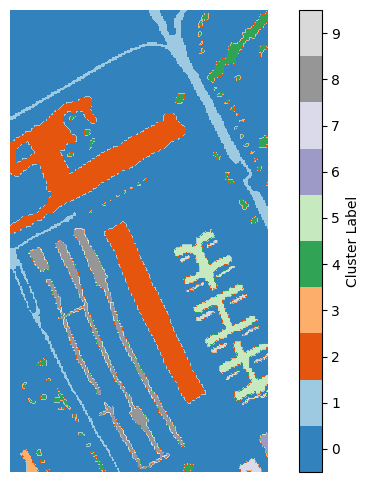

In [5]:
# plot ground truth data
def plot_data(data, n_clusters):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    plt.axis('off')
    cmap = cm.get_cmap('tab20c', n_clusters)
    plt.imshow(data, cmap=cmap)
    cbar = plt.colorbar(label='Cluster Label')
    tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(np.arange(n_clusters))
    plt.show()

plot_data(gt, 10)

In [6]:
# reshape the input data from rcb to samples and features
data_reshaped = data_array.reshape(data_array.shape[0]*data_array.shape[1], -1)
data_reshaped = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)
gt_reshaped = gt.flatten()

# Incremental PCA

In [7]:
from sklearn.decomposition import IncrementalPCA
pca = IncrementalPCA(n_components=5)
selected_components = pca.fit_transform(data_reshaped)

# K-means

In [8]:
# k-means clustering using the components generated in the previous cell
k_means = cluster.KMeans(n_clusters=10, random_state=1) # create an object of the classifier

search_space = {
    'max_iter': Integer(100, 300),
    'tol': Real(0.0001, 0.01)
    }

bayes_search = BayesSearchCV(k_means, search_space, n_iter=50, # specify how many iterations
                             scoring='v_measure_score', n_jobs=-1, verbose=1, random_state=1)

bayes_search.fit(selected_components, gt_reshaped) # callback=on_step will print score after each iteration

print('\n', bayes_search.best_estimator_)
print('\nBest V-measure:', bayes_search.best_score_)

# Best V-measure: 0.22853249357457078
# max_iter=230, tol=0.0010575184942044017

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

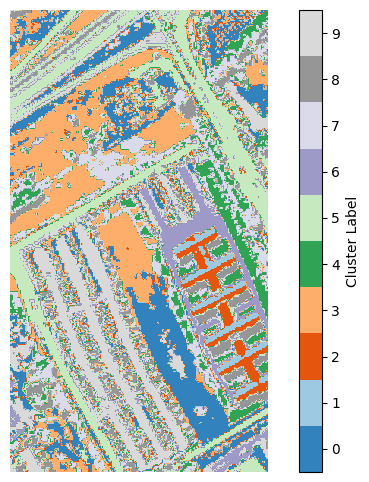

In [9]:
# k-means clustering using the selected components
k_means = cluster.KMeans(n_clusters=10, max_iter=230, tol=0.0010575184942044017, random_state=1) # create an object of the classifier
labels = k_means.fit_predict(selected_components)
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 10)

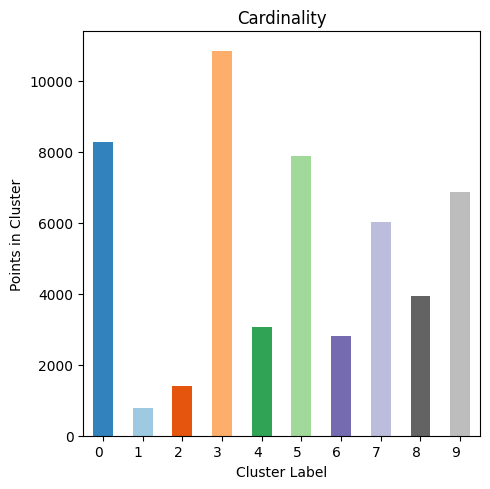

In [10]:
n_clusters = 10
colors = cm.tab20c([x/n_clusters for x in list(range(n_clusters+1))])

fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster_cardinality(k_means.labels_, ax=ax, title='Cardinality', color=colors)
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

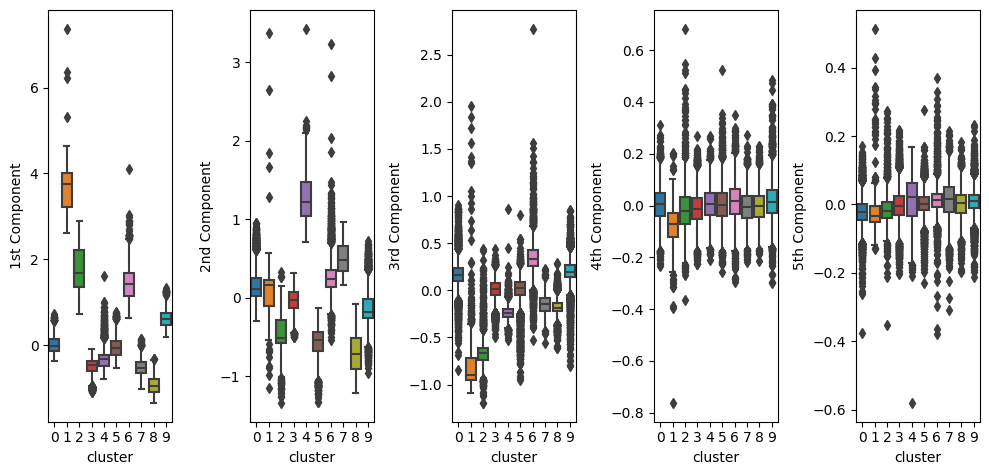

In [11]:
features = ['1st Component', '2nd Component','3rd Component', '4th Component', '5th Component']
selected_components_df = pd.DataFrame(selected_components, columns=features)
selected_components_df['cluster'] = k_means.labels_

ncols = 5
nrows = len(features) // ncols + (len(features) % ncols > 0)

fig = plt.figure(figsize=(10, 5))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n+1)
    box = sns.boxplot(x='cluster', y=feature, data=selected_components_df)

fig.suptitle('')
plt.tight_layout()
plt.show()

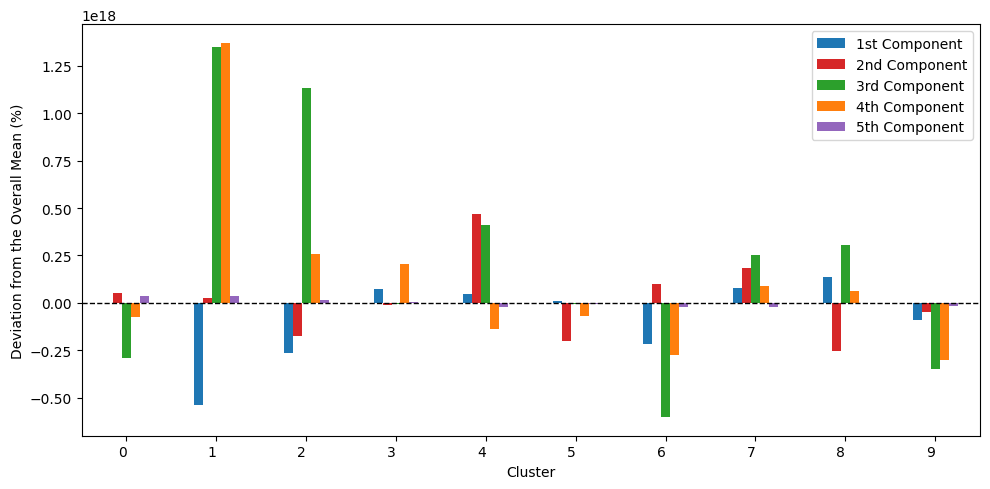

In [12]:
selected_components_mean = pd.concat([pd.DataFrame(selected_components_df.mean().drop('cluster'), columns=['mean']),
                                      selected_components_df.groupby('cluster').mean().T], axis=1)
selected_components_dev_rel = selected_components_mean.apply(lambda x: round((x-x['mean'])/x['mean'], 2)*100, axis=1)

selected_components_dev_rel.drop(columns=['mean'], inplace=True)
selected_components_mean.drop(columns=['mean'], inplace=True)

fig = plt.figure(figsize=(10, 5))

selected_components_dev_rel.T.plot(kind='bar',
                                   ax=fig.add_subplot(),
                                   color=['tab:blue', 'tab:red','tab:green','tab:orange','tab:purple'],
                                   xlabel='Cluster',
                                   ylabel='Deviation from the Overall Mean (%)'
                                  )

plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(loc='best')
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

In [13]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(7, 13))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_pca = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = cluster.KMeans(n_clusters=n_clusters, max_iter=112, tol=0.001, random_state=1)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score
                   # the minimum score is zero, and the lower values the better clustering performance
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0
                   # 1.0 stands for perfectly homogeneous labelling
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0
                   # 1.0 stands for perfectly complete labelling
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0
                   # random labellings have an ARI close to 0.0
                   # 1.0 stands for perfect match
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched)
                   # random partitions (independent labellings) have an expected AMI around 0 on average hence can be negative
                   # the value is in adjusted nats (based on the natural logarithm)
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_pca.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_pca.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
7.0,0.373115,39573.128312,0.838473,0.325281,0.168903,0.222350,0.442843,0.014801,0.286881,0.222030
8.0,0.345896,39090.918793,0.889442,0.340846,0.157042,0.215017,0.430851,0.015166,0.300608,0.214669
9.0,0.361928,41141.758502,0.815908,0.360311,0.161217,0.222761,0.430124,0.015681,0.317775,0.222374
10.0,0.357191,41607.818818,0.806245,0.365578,0.153171,0.215889,0.425047,0.015315,0.322421,0.215469
11.0,0.354001,40922.328631,0.844707,0.377033,0.152307,0.216967,0.422580,0.014048,0.332523,0.216512
12.0,0.356133,40486.265692,0.823447,0.376663,0.149679,0.214228,0.421993,0.014480,0.332197,0.213729


# MiniBatch K-means

In [14]:
# minibatch k-means clustering using the slected components
minibatch_kmeans = cluster.MiniBatchKMeans(n_clusters=10, random_state=1) # create an object of the classifier

search_space = {
    'max_iter': Integer(50, 150),
    'batch_size': Integer(512, 2048)
    }

bayes_search = BayesSearchCV(minibatch_kmeans, search_space, n_iter=50, # specify how many iterations
                                scoring='v_measure_score', n_jobs=-1, verbose=1, random_state=1)

bayes_search.fit(selected_components, gt_reshaped) # callback=on_step will print score after each iteration

print('\n', bayes_search.best_estimator_)
print('\nBest V-measure:', bayes_search.best_score_)

# Best V-measure: 0.23508763506256175
# batch_size=1450, max_iter=85

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

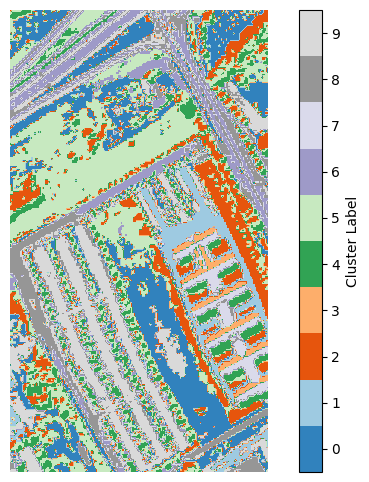

In [15]:
# minibatch k-means clustering using the selected components
minibatch_kmeans = cluster.MiniBatchKMeans(n_clusters=10, max_iter=85, batch_size=1450, random_state=1) # create an object of the classifier
labels = minibatch_kmeans.fit_predict(selected_components)
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 10)

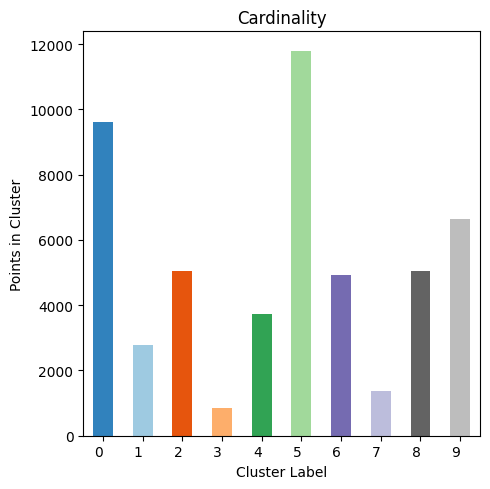

In [16]:
n_clusters = 10
colors = cm.tab20c([x/n_clusters for x in list(range(n_clusters+1))])

fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster_cardinality(minibatch_kmeans.labels_, ax=ax, title='Cardinality', color=colors)
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

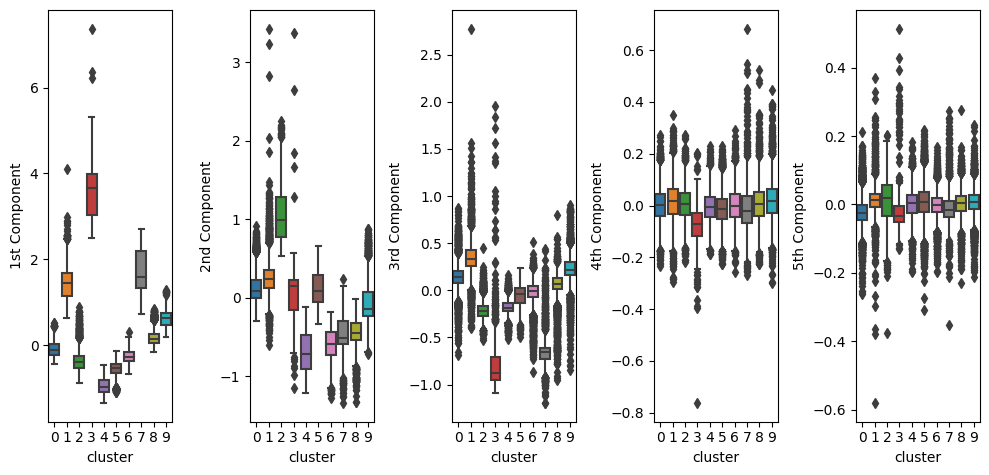

In [17]:
features = ['1st Component', '2nd Component','3rd Component', '4th Component', '5th Component']
selected_components_df = pd.DataFrame(selected_components, columns=features)
selected_components_df['cluster'] = minibatch_kmeans.labels_

ncols = 5
nrows = len(features) // ncols + (len(features) % ncols > 0)

fig = plt.figure(figsize=(10, 5))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n+1)
    box = sns.boxplot(x='cluster', y=feature, data=selected_components_df)



fig.suptitle('')
plt.tight_layout()
plt.show()

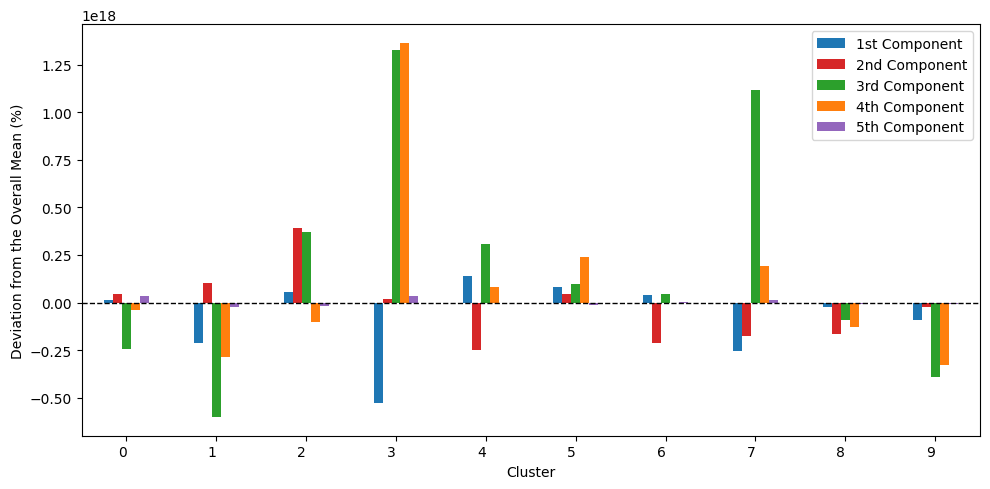

In [18]:
selected_components_mean = pd.concat([pd.DataFrame(selected_components_df.mean().drop('cluster'), columns=['mean']),
                                      selected_components_df.groupby('cluster').mean().T], axis=1)
selected_components_dev_rel = selected_components_mean.apply(lambda x: round((x-x['mean'])/x['mean'], 2)*100, axis=1)

selected_components_dev_rel.drop(columns=['mean'], inplace=True)
selected_components_mean.drop(columns=['mean'], inplace=True)

fig = plt.figure(figsize=(10, 5))

selected_components_dev_rel.T.plot(kind='bar',
                                   ax=fig.add_subplot(),
                                   color=['tab:blue', 'tab:red','tab:green','tab:orange','tab:purple'],
                                   xlabel='Cluster',
                                   ylabel='Deviation from the Overall Mean (%)'
                                  )

plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(loc='best')
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(8, 13))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_minibatch_kmeans = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = cluster.MiniBatchKMeans(n_clusters=n_clusters, max_iter=85, batch_size=1450, random_state=1)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score
                   # the minimum score is zero, and the lower values the better clustering performance
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0
                   # 1.0 stands for perfectly homogeneous labelling
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0
                   # 1.0 stands for perfectly complete labelling
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0
                   # random labellings have an ARI close to 0.0
                   # 1.0 stands for perfect match
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched)
                   # random partitions (independent labellings) have an expected AMI around 0 on average hence can be negative
                   # the value is in adjusted nats (based on the natural logarithm)
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_minibatch_kmeans.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_minibatch_kmeans.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
8.0,0.349322,37937.606693,0.839076,0.350060,0.166245,0.225431,0.436575,0.020235,0.308734,0.225079
9.0,0.356948,40575.171653,0.827085,0.358337,0.159356,0.220607,0.429816,0.016137,0.316035,0.220220
10.0,0.333126,38986.826490,0.897454,0.358017,0.150342,0.211759,0.425626,0.014980,0.315752,0.211336
11.0,0.324463,38267.515158,0.918390,0.368542,0.145704,0.208842,0.421687,0.015689,0.325034,0.208390
12.0,0.322737,37341.218256,0.927759,0.376997,0.144978,0.209421,0.419307,0.013726,0.332492,0.208932


# Bisecting K-means

In [20]:
# bisecting k-means clustering using the selected components
bisecting_kmeans = cluster.BisectingKMeans(n_clusters=10, random_state=1) # create an object of the classifier

search_space = {
    'max_iter': Integer(100, 300),
    'bisecting_strategy': Categorical(['biggest_inertia', 'largest_cluster'])
    }

bayes_search = BayesSearchCV(bisecting_kmeans, search_space, n_iter=50, # specify how many iterations
                             scoring='v_measure_score', n_jobs=-1, verbose=1, random_state=1)

bayes_search.fit(selected_components, gt_reshaped) # callback=on_step will print score after each iteration

print('\n', bayes_search.best_estimator_)
print('\nBest V-measure:', bayes_search.best_score_)

# Best V-measure: 0.19432783102807544
# max_iter=248, bisecting_strategy='biggest_inertia'

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

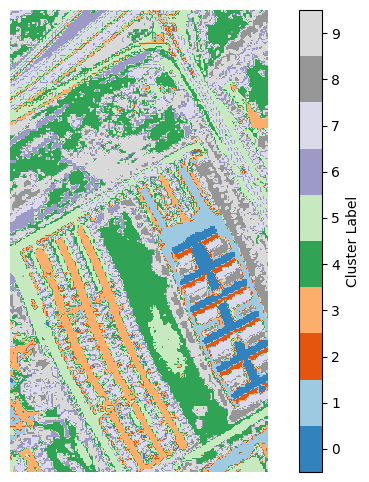

In [21]:
# bisecting k-means clustering using the selected components
bisecting_kmeans = cluster.BisectingKMeans(n_clusters=10, max_iter=248, random_state=1) # create an object of the classifier
labels = bisecting_kmeans.fit_predict(selected_components)
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 10)

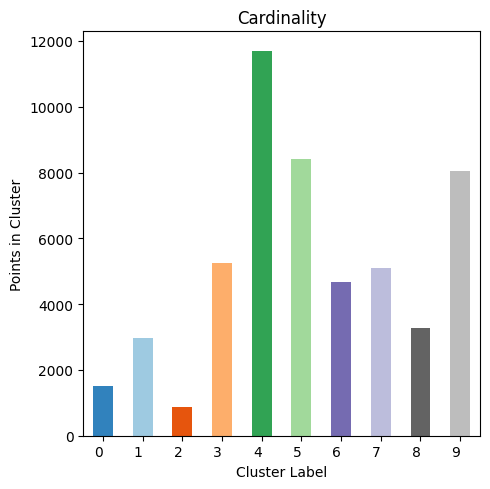

In [22]:
n_clusters = 10
colors = cm.tab20c([x/n_clusters for x in list(range(n_clusters+1))])

fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster_cardinality(bisecting_kmeans.labels_, ax=ax, title='Cardinality', color=colors)
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

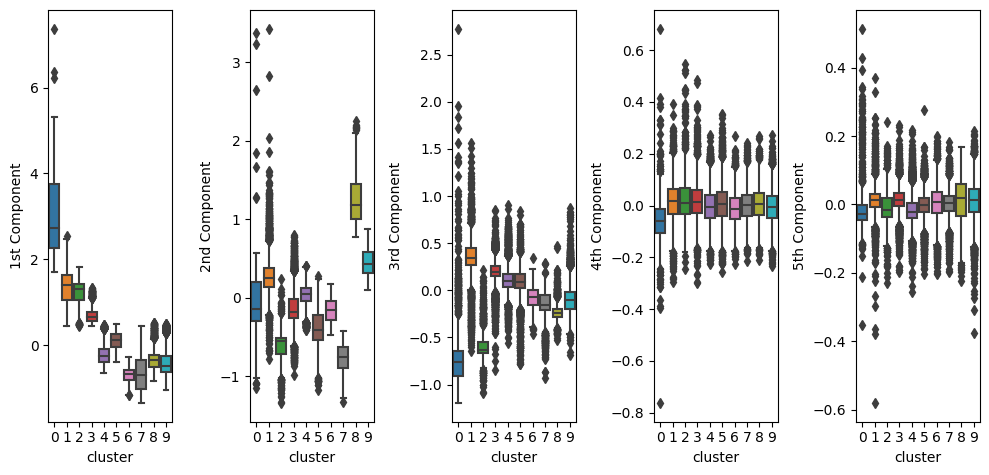

In [23]:
features = ['1st Component', '2nd Component','3rd Component', '4th Component', '5th Component']
selected_components_df = pd.DataFrame(selected_components, columns=features)
selected_components_df['cluster'] = bisecting_kmeans.labels_

ncols = 5
nrows = len(features) // ncols + (len(features) % ncols > 0)

fig = plt.figure(figsize=(10, 5))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n+1)
    box = sns.boxplot(x='cluster', y=feature, data=selected_components_df)

fig.suptitle('')
plt.tight_layout()
plt.show()

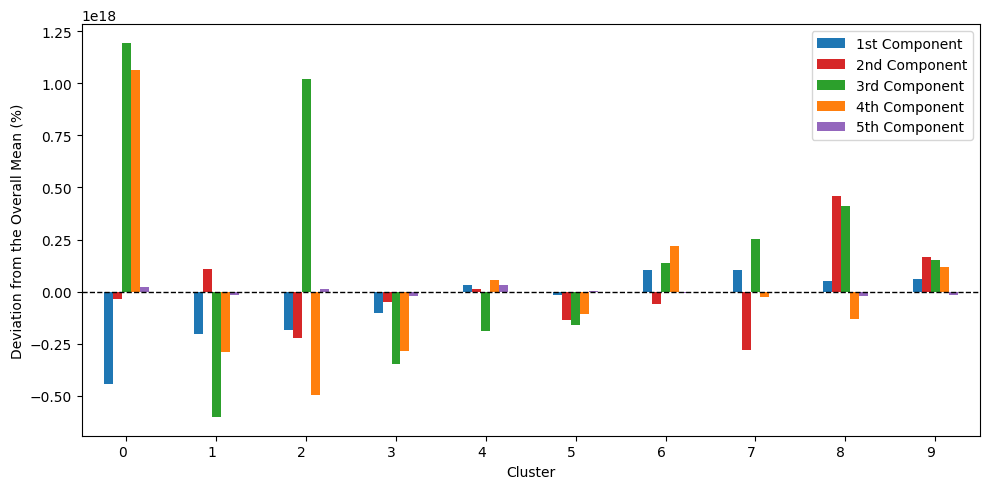

In [24]:
selected_components_mean = pd.concat([pd.DataFrame(selected_components_df.mean().drop('cluster'), columns=['mean']),
                                      selected_components_df.groupby('cluster').mean().T], axis=1)
selected_components_dev_rel = selected_components_mean.apply(lambda x: round((x-x['mean'])/x['mean'], 2)*100, axis=1)

selected_components_dev_rel.drop(columns=['mean'], inplace=True)
selected_components_mean.drop(columns=['mean'], inplace=True)

fig = plt.figure(figsize=(10, 5))

selected_components_dev_rel.T.plot(kind='bar',
                                   ax=fig.add_subplot(),
                                   color=['tab:blue', 'tab:red','tab:green','tab:orange','tab:purple'],
                                   xlabel='Cluster',
                                   ylabel='Deviation from the Overall Mean (%)'
                                  )

plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(loc='best')
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

In [25]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(8, 13))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_bisecting_kmeans = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = cluster.BisectingKMeans(n_clusters=n_clusters, max_iter=248, random_state=1)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score
                   # the minimum score is zero, and the lower values the better clustering performance
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0
                   # 1.0 stands for perfectly homogeneous labelling
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0
                   # 1.0 stands for perfectly complete labelling
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0
                   # random labellings have an ARI close to 0.0
                   # 1.0 stands for perfect match
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched)
                   # random partitions (independent labellings) have an expected AMI around 0 on average hence can be negative
                   # the value is in adjusted nats (based on the natural logarithm)
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_bisecting_kmeans.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_bisecting_kmeans.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
8.0,0.282488,33116.358680,1.003925,0.285398,0.130450,0.179057,0.432155,0.018689,0.251706,0.178695
9.0,0.280443,32738.527562,1.021954,0.307693,0.131725,0.184475,0.424505,0.012463,0.271369,0.184083
10.0,0.287052,32913.858430,0.958083,0.325023,0.135972,0.191733,0.425035,0.014689,0.286653,0.191300
11.0,0.291266,33771.696182,0.932993,0.325628,0.134956,0.190824,0.425006,0.014802,0.287187,0.190344
12.0,0.296955,33617.683858,0.916182,0.332654,0.132096,0.189101,0.419294,0.008878,0.293383,0.188587


# BIRCH

In [26]:
# birch clustering using the selected components
birch = cluster.Birch(n_clusters=10) # create an object of the classifier

search_space = {
    'branching_factor': Integer(10, 100)
    }

bayes_search = BayesSearchCV(birch, search_space, n_iter=50, # specify how many iterations
                                scoring='v_measure_score', n_jobs=-1, verbose=1, random_state=1)

bayes_search.fit(selected_components, gt_reshaped) # callback=on_step will print score after each iteration

print('\n', bayes_search.best_estimator_)
print('\nBest V-measure:', bayes_search.best_score_)

# Best V-measure: 0.21445307575898154
# branching_factor=20

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

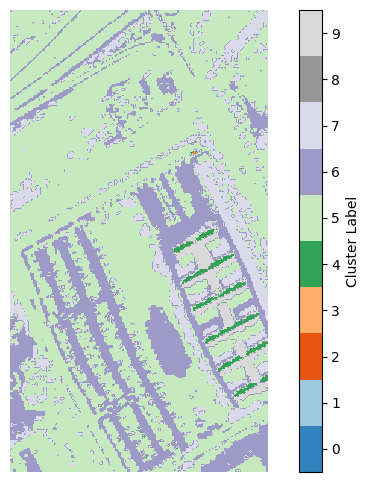

In [27]:
# birch clustering using the selected components
birch = cluster.Birch(n_clusters=10, branching_factor=20) # create an object of the classifier
labels = birch.fit_predict(selected_components)
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 10)

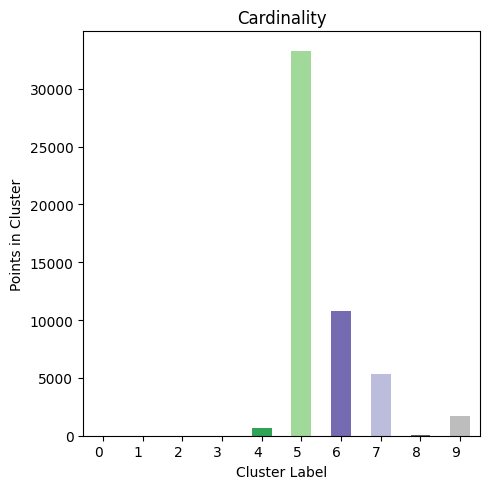

In [28]:
n_clusters = 10
colors = cm.tab20c([x/n_clusters for x in list(range(n_clusters+1))])

fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster_cardinality(birch.labels_, ax=ax, title='Cardinality', color=colors)
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

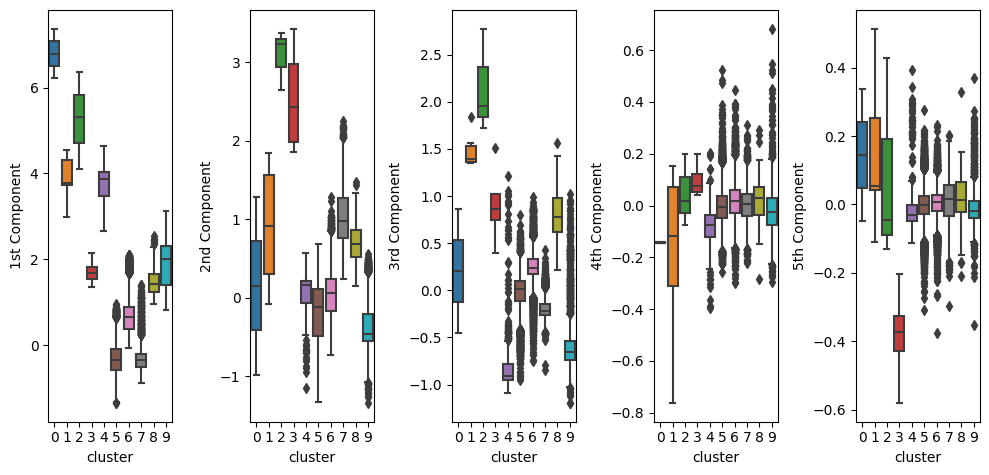

In [29]:
features = ['1st Component', '2nd Component','3rd Component', '4th Component', '5th Component']
selected_components_df = pd.DataFrame(selected_components, columns=features)
selected_components_df['cluster'] = birch.labels_

ncols = 5
nrows = len(features) // ncols + (len(features) % ncols > 0)

fig = plt.figure(figsize=(10, 5))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n+1)
    box = sns.boxplot(x='cluster', y=feature, data=selected_components_df)

fig.suptitle('')
plt.tight_layout()
plt.show()

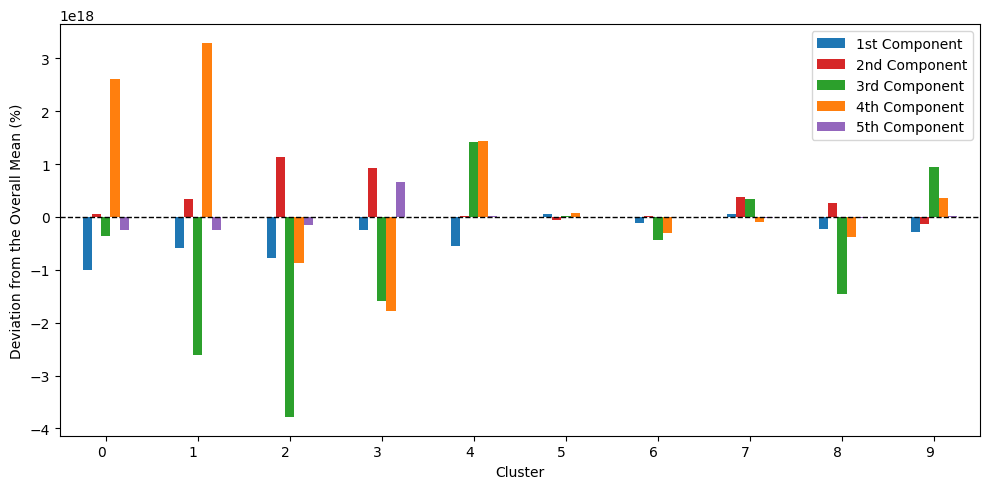

In [30]:
selected_components_mean = pd.concat([pd.DataFrame(selected_components_df.mean().drop('cluster'), columns=['mean']),
                                      selected_components_df.groupby('cluster').mean().T], axis=1)
selected_components_dev_rel = selected_components_mean.apply(lambda x: round((x-x['mean'])/x['mean'], 2)*100, axis=1)

selected_components_dev_rel.drop(columns=['mean'], inplace=True)
selected_components_mean.drop(columns=['mean'], inplace=True)

fig = plt.figure(figsize=(10, 5))

selected_components_dev_rel.T.plot(kind='bar',
                                   ax=fig.add_subplot(),
                                   color=['tab:blue', 'tab:red','tab:green','tab:orange','tab:purple'],
                                   xlabel='Cluster',
                                   ylabel='Deviation from the Overall Mean (%)'
                                  )

plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(loc='best')
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

In [31]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(8, 13))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_birch = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = cluster.Birch(n_clusters=n_clusters, branching_factor=20)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score
                   # the minimum score is zero, and the lower values the better clustering performance
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0
                   # 1.0 stands for perfectly homogeneous labelling
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0
                   # 1.0 stands for perfectly complete labelling
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0
                   # random labellings have an ARI close to 0.0
                   # 1.0 stands for perfect match
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched)
                   # random partitions (independent labellings) have an expected AMI around 0 on average hence can be negative
                   # the value is in adjusted nats (based on the natural logarithm)
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_birch.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_birch.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
8.0,0.357238,13562.307671,0.777959,0.198820,0.177557,0.187588,0.515287,0.044171,0.175349,0.187248
9.0,0.334186,12002.397078,0.795373,0.199381,0.176231,0.187092,0.514936,0.043801,0.175843,0.186687
10.0,0.341145,12364.167055,0.778865,0.200861,0.172901,0.185835,0.514958,0.044201,0.177149,0.185355
11.0,0.341129,11131.723618,0.696550,0.200892,0.172923,0.185861,0.514958,0.044201,0.177176,0.185372
12.0,0.341079,10123.427608,0.662481,0.200892,0.172909,0.185853,0.514958,0.044201,0.177176,0.185349


# Gaussian Mixture

In [32]:
# gaussian mixture clustering using the selected components
gaussian_mix = mixture.GaussianMixture(n_components=10) # create an object of the classifier

search_space = {
    'covariance_type': Categorical(['full', 'tied', 'diag', 'spherical']),
    'tol': Real(1e-5, 1e-2)
    }

bayes_search = BayesSearchCV(gaussian_mix, search_space, n_iter=50, # specify how many iterations
                             scoring='v_measure_score', n_jobs=-1, verbose=1, random_state=1)

bayes_search.fit(selected_components, gt_reshaped) # callback=on_step will print score after each iteration

print('\n', bayes_search.best_estimator_)
print('\nBest V-measure:', bayes_search.best_score_)

# Best V-measure: 0.2360132940426852
# Best Parameters: covariance_type = diag, tol=0.0019906653337710377

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

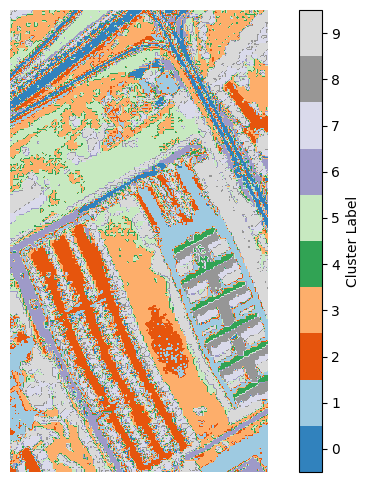

In [33]:
# gaussian mixure using the selected components
gaussian_mix = mixture.GaussianMixture(n_components=10, covariance_type='diag', tol=0.01, random_state=1) # create an object of the classifier
labels = gaussian_mix.fit_predict(selected_components)
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 10)

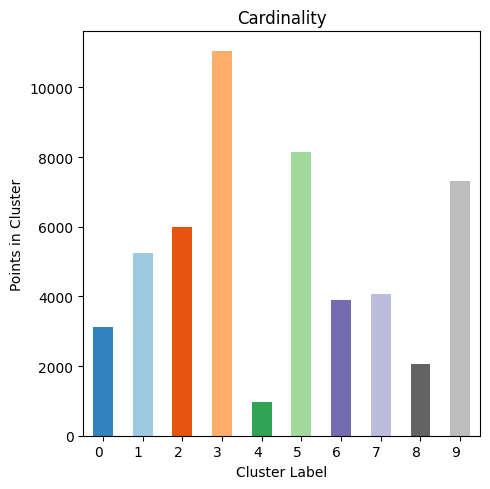

In [34]:
n_clusters = 10
colors = cm.tab20c([x/n_clusters for x in list(range(n_clusters+1))])

fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster_cardinality(labels, ax=ax, title='Cardinality', color=colors)
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

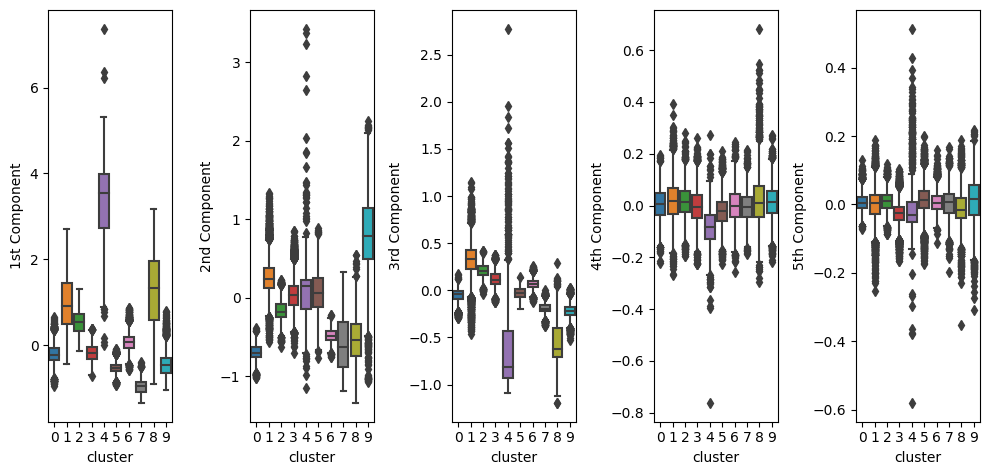

In [35]:
features = ['1st Component', '2nd Component','3rd Component', '4th Component', '5th Component']
selected_components_df = pd.DataFrame(selected_components, columns=features)
selected_components_df['cluster'] = labels

ncols = 5
nrows = len(features) // ncols + (len(features) % ncols > 0)

fig = plt.figure(figsize=(10, 5))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n+1)
    box = sns.boxplot(x='cluster', y=feature, data=selected_components_df)

fig.suptitle('')
plt.tight_layout()
plt.show()

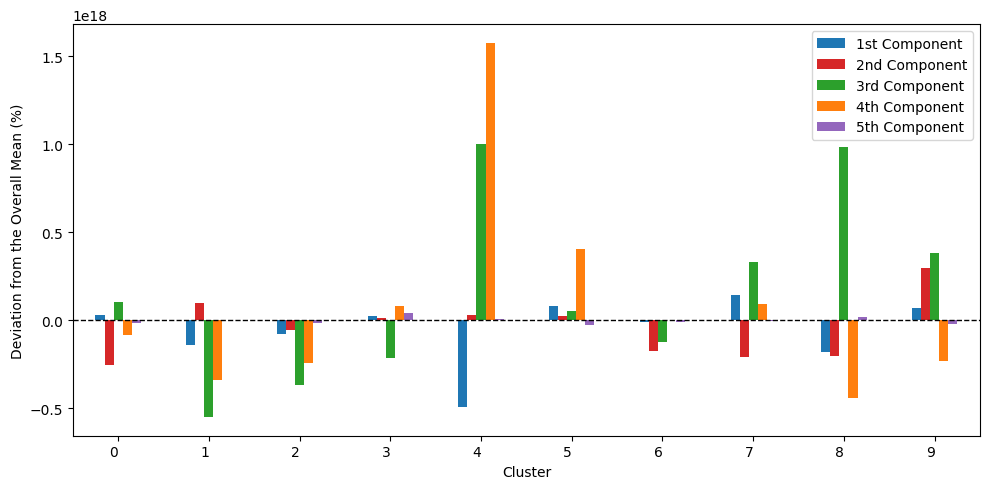

In [36]:
selected_components_mean = pd.concat([pd.DataFrame(selected_components_df.mean().drop('cluster'), columns=['mean']),
                                      selected_components_df.groupby('cluster').mean().T], axis=1)
selected_components_dev_rel = selected_components_mean.apply(lambda x: round((x-x['mean'])/x['mean'], 2)*100, axis=1)

selected_components_dev_rel.drop(columns=['mean'], inplace=True)
selected_components_mean.drop(columns=['mean'], inplace=True)

fig = plt.figure(figsize=(10, 5))

selected_components_dev_rel.T.plot(kind='bar',
                                   ax=fig.add_subplot(),
                                   color=['tab:blue', 'tab:red','tab:green','tab:orange','tab:purple'],
                                   xlabel='Cluster',
                                   ylabel='Deviation from the Overall Mean (%)'
                                  )

plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(loc='best')
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

In [37]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(8, 13))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_gaussian_mix = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='diag', tol=0.0019906653337710377, random_state=1)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score
                   # the minimum score is zero, and the lower values the better clustering performance
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0
                   # 1.0 stands for perfectly homogeneous labelling
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0
                   # 1.0 stands for perfectly complete labelling
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0
                   # random labellings have an ARI close to 0.0
                   # 1.0 stands for perfect match
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched)
                   # random partitions (independent labellings) have an expected AMI around 0 on average hence can be negative
                   # the value is in adjusted nats (based on the natural logarithm)
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_gaussian_mix.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_gaussian_mix.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
8.0,0.219479,19554.247741,2.300201,0.362802,0.162713,0.224665,0.432986,0.023423,0.319972,0.224329
9.0,0.212406,19416.779253,1.181059,0.380643,0.164558,0.229779,0.436746,0.032742,0.335707,0.229405
10.0,0.180774,17678.538504,1.225791,0.375177,0.154916,0.219285,0.433931,0.031551,0.330886,0.218872
11.0,0.175232,18096.622104,1.706555,0.391521,0.157354,0.224486,0.431700,0.029575,0.345301,0.224038
12.0,0.180871,19216.457572,1.644494,0.399778,0.151230,0.219446,0.424223,0.024693,0.352583,0.218971
